<a href="https://colab.research.google.com/github/myselfhimself/gmic-py/blob/master/GColabEditableGithubSynced_GmicNumpySpecification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFC Specification of Numpy Input/Output Presets with the G'MIC Python binding


Users and developers of the Numpy, PIL and ScikitImage communities are invited to review and edit this document.

[G'MIC](https://gmic.eu) is a full-featured image processing framework. In order to further the development of the G'MIC Python binding and make it friendly to use with Numpy users, we are developping proper I/O conversion methods and presets.

In G'MIC Python, a G'MIC image is typed `gmic.GmicImage`.
In Numpy, an image is typed as `numpy.ndarray`.
The stake of this document is to simplify and bulletproof data exchange between both types.

Numpy-based image libraries store their data with specificities for each, in terms of:
- shape axes positioning,
- pixel values (de)interleaving,
- data type.
Therefore we introduce here presets to help simplify programming for end-users of Numpy (agnostic or G'MIC-like), PIL (or Pillow) or ScikitImage, without sacrificing custom-made programming.

The following chapters present:
1. Basic GmicImage->numpy.ndarray conversion
1. Basic numpy.ndarray->GmicImage conversion
1. The G'MIC Numpy format preset
1. The interleaved Numpy format preset (proposal)
1. The PIL format preset (proposal)
1. The ScikitImage format preset (proposal)

Each chapter is followed by a *Proof example* part which actually proves directly using the latest importable `gmic` module, that the input and output conversions using each preset do work!

In [4]:
!pip install gmic==2.9.1-alpha1
!pip install numpy
!pip install scikit-image
!pip install Pillow

     |████████████████████████████████| 8.8MB 3.2MB/s 


# Basic GmicImage -> numpy.ndarray conversion

gmic-py: Working in display-less mode.


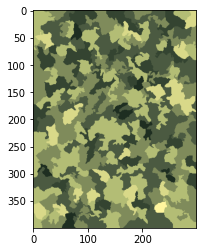

In [ ]:
import gmic
import numpy
ii = [] # This list will be filled a G'MIC-generated image
gmic.run("300,400,1,3 fx_camouflage 9,12,100,30,46,33,75,90,65,179,189,117,255,246,158 display", ii) # Filling ii in-place with a camouflage

In [ ]:
# The resulting GmicImage's shape is expressed with letters w,h,d,s in this order: width, height, depth, spectrum(or channels)
# Other image libraries will probably store those 1-4 dimensions in a different order.
print(ii)

# Note that G'MIC has channel values deinterleaved:
# - R1G1B1,R2G2B2,R3G3B3 is how the usual image world stores pixels values, ie. "interleaved";
# - R1R2R3,G1G2G3,B1B2B3 is how G'MIC stores pixel values, ie. "deinterleaved".

# Now, let us convert towards Numpy, with pixels interleaving
arr = ii[0].to_numpy_array(interleave=True, permute="", astype=numpy.uint8, preset="i_yxz") # TODO fix parameters and keep interleave=True only

# Checking nparray's traits
print(type(arr))
print(arr.dtype)
arr.shape # shape inchangé par rapport à G'MIC: w,h,d,s

# Basic numpy.ndarray -> GmicImage conversion

In [ ]:
import numpy
import gmic
import struct

a = numpy.arange(45).reshape(3, 5, 1, 3)
print(a)
print(a.shape)

# Now, let us convert from Numpy to GmicImage, with pixels deinterleaving
g = gmic.GmicImage.from_numpy_array(a, deinterleave=True) # TODO fix parameters and keep interleave=True only

# verification des caractéristiques du nparray
print(g) # TODO GmicImage shape is 3,5,1,1 instead of 3,5,1,1!!!
print(type(g))
print(struct.unpack('45f',g._data))

[[[[ 0  1  2]]

  [[ 3  4  5]]

  [[ 6  7  8]]

  [[ 9 10 11]]

  [[12 13 14]]]


 [[[15 16 17]]

  [[18 19 20]]

  [[21 22 23]]

  [[24 25 26]]

  [[27 28 29]]]


 [[[30 31 32]]

  [[33 34 35]]

  [[36 37 38]]

  [[39 40 41]]

  [[42 43 44]]]]
(3, 5, 1, 3)
<gmic.GmicImage object at 0x7f9075b93300 with _data address at 0x3023500, w=5 h=3 d=1 s=1 shared=0>
<class 'gmic.GmicImage'>


error: ignored

# The G'MIC Numpy format preset

The aim of this preset is to allow G'MIC images to be converted without any change in content nature and layout from and to Numpy, in the G'MIC-sense (ie. float32).

Here is a how a Numpy ndarray or GmicImage is like for this preset:
*   **pixel channel values**: agnostic, untouched, if coming from GmicImage or `numpy.ndarray`, not even deinterleaved or interleaved;
*   **data type**: float32, ie. G'MIC's own pixel value data type;
*   **shape**: w,h,d,s or agnostic, if coming from GmicImage `numpy.ndarray`, no reshaping or permuting is done.
*   **input call signature**: GmicImage.from_numpy_array(gmic.NUMPY_FORMAT_GMIC) -> GmicImage
*   **output call signature**: gmicimageobject.to_numpy_array(gmic.NUMPY_FORMAT_GMIC) -> numpy.ndarray


In [ ]:
# Proof example
# gmic -> numpy with gmic.NUMPY_FORMAT_GMIC
# TODO
# gmic <- numpy with gmic.NUMPY_FORMAT_GMIC
# TODO

# The interleaved Numpy format preset (default) (proposal)
The aim of this preset is to allow G'MIC images to be converted without any change in content nature and layout from and to Numpy, in the Numpy-sense (ie. pixel channel values interleaved, shape axes flipped but for the spectrum/colors staying latest). This is the default preset.

Here is a how a Numpy ndarray or GmicImage is like for this preset:
*   **pixel channel values**:
  - numpy.ndarray -> GmicImage: deinterleaved;
  - GmicImage -> numpy.ndarray: interleaved;
*   **data type**: 
  - numpy.ndarray -> GmicImage: float32, ie. G'MIC's own pixel value data type;
  - GmicImage -> numpy.ndarray: float32 by default or the type specified by the `astype=numpy.sometype` parameter;
*   **shape**:
  - numpy.ndarray -> GmicImage: w,h,d,s, ie. G'MIC's traditional shape;
  - GmicImage -> numpy.ndarray: d,h,w,s (ie. zxyc);
*   **input call signature**: GmicImage.from_numpy_array(gmic.NUMPY_FORMAT_DEFAULT) -> GmicImage
*   **output call signature**: gmicimageobject.to_numpy_array(gmic.NUMPY_FORMAT_DEFAULT) -> numpy.ndarray


In [ ]:
# Proof example
# gmic -> numpy with gmic.NUMPY_FORMAT_DEFAULT
# TODO
# gmic <- numpy with gmic.NUMPY_FORMAT_DEFAULT
# TODO

# The PIL format preset (proposal)
The aim of this preset is to allow G'MIC images to be converted back and forth easily with PIL, especially be displayable without change in both worlds (eg. using Matplotlib for PIL ndarray, G'MIC's display window for GmicImage).

Here is a how a Numpy ndarray or GmicImage is like for this preset:
*   **pixel channel values**:
  - numpy.ndarray -> GmicImage: deinterleaved;
  - GmicImage -> numpy.ndarray: interleaved;
*   **data type**:
  - numpy.ndarray -> GmicImage: float32, ie. G'MIC's own pixel value data type;
  - GmicImage -> numpy.ndarray: float32 by default or the type specified by the `astype=numpy.sometype` parameter;
*   **shape**:
  - numpy.ndarray -> GmicImage: w,h,d,s, ie. G'MIC's traditional shape;
  - GmicImage -> numpy.ndarray: h,w,(d,)s (ie. xyzc), with d=1 squeezed, ie. h,w,1,s -> h,w,s;
*   **input call signature**:
  - GmicImage.from_numpy_array(numpy.ndarray|PIL.Image, gmic.NUMPY_FORMAT_PIL) -> GmicImage
  - GmicImage.from_PIL(numpy.ndarray|PIL.Image) -> GmicImage
*   **output call signature**: 
  - gmicimageobject.to_numpy_array(gmic.NUMPY_FORMAT_PIL) -> numpy.ndarray
  - gmicimageobject.to_PIL() -> PIL.Image

400 400 RGB PNG <class 'PIL.PngImagePlugin.PngImageFile'>


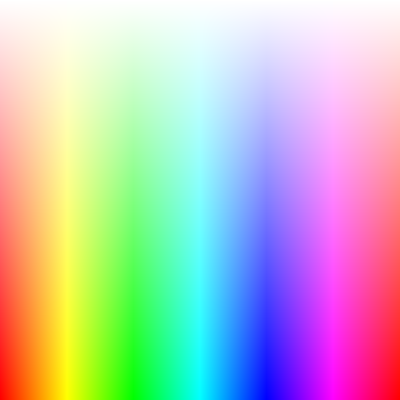

400 400 RGB None <class 'PIL.Image.Image'>


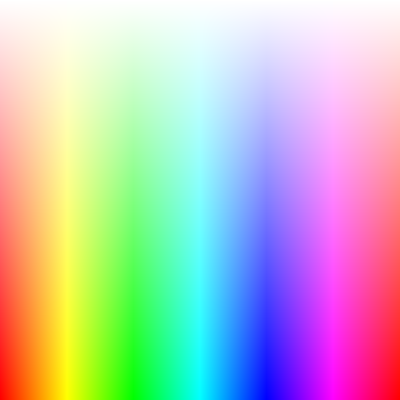

[gmic]-1./ 'from_PIL'
[gmic]-1./ Display image [0], from point (200,200,0) (console output only, no display available).
[0] = '[unnamed]':
  size = (400,400,1,3) [1875 Kio of floats].
  data = (255,255,255,255,255,255,255,255,255,255,255,255,(...),42,38,34,30,26,23,19,15,11,7,3,0).
  min = 0, max = 255, mean = 190.863, std = 74.8873, coords_min = (133,398,0,0), coords_max = (0,0,0,0).


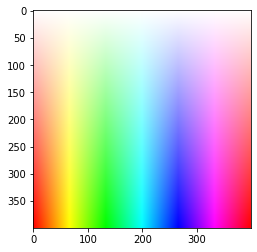

In [60]:
# Proof example
#### gmic -> numpy with gmic.NUMPY_FORMAT_PIL ####
# I - pure-python implementation test
import PIL.Image
import gmic
import numpy
%matplotlib inline

# def to_PIL_without_numpy(gmicimage):
#   # I failed to find a proper raw decoder for 32-bits RGB deinterleaved
#   # too lazy to implement a custom decoder for now
#   return PIL.Image.frombytes('RGB', (gmicimage._width, gmicimage._height), gmicimage._data, 'raw', 'RGBX') # per https://github.com/python-pillow/Pillow/blob/c841501c3416bf245b5688dd33890641ef0f5dd7/src/libImaging/Unpack.c#L1342

def to_PIL(gmicimage, astype=numpy.uint8, squeeze=True, mode='RGB'):
  arr = gmicimage.to_numpy_array(astype=numpy.uint8)
  #print("yo", arr.shape, arr.dtype)
  return PIL.Image.fromarray(arr.squeeze() if squeeze else arr, mode)

# Color ramp generating command from https://gmic.eu/gallery/colors.shtml since G'MIC samples downloads are blocked by GColab
GMIC_GENERATE_COLORS_IMAGE_COMMAND = "(0,360;0,360^0,0;1,1^1,1;1,1) resize 400,400,1,3,3 hsv2rgb"

# 1. Generate and image and store it to file
l = []
gmic.run(GMIC_GENERATE_COLORS_IMAGE_COMMAND + " output colors.png", l)

# 2. Load the file-output image from PIL and display for visual comparison
im=PIL.Image.open('colors.png')
print(im.width, im.height, im.mode, im.format, type(im))
display(im)

# 3. Make G'MIC Image into a PIL Image through Numpy and display
l_as_PIL = to_PIL(l[0])
print(l_as_PIL.width, l_as_PIL.height, l_as_PIL.mode, l_as_PIL.format, type(l_as_PIL))
display(l_as_PIL)


# II - C/Python implementation test
# TODO

#### gmic <- numpy with gmic.NUMPY_FORMAT_PIL ####
# I - pure-python implementation test
def from_PIL(PILimage):
  gmicimage = gmic.GmicImage.from_numpy_array(numpy.array(PILimage), deinterleave=True)
  return gmicimage

# 2. Load the file-output image from PIL and display for visual comparison
im2=PIL.Image.open('colors.png')
gmicim2 = from_PIL(im2)
gmic.run("echo 'from_PIL' display", gmicim2)

# II - C/Python implementation test
# TODO

# The ScikitImage format preset (proposal)
The aim of this preset is to allow G'MIC images to be converted back and forth easily with ScikitImage, especially be displayable without change in both worlds (eg. using `skimage.viewer` for ScikitImage ndarray, G'MIC's display window for GmicImage).
This is very similar to the interleaved Numpy preset, except for the output shape which has the depth axis first.

Here is a how a Numpy ScikitImage ndarray or GmicImage is like for this preset:
*   **pixel channel values**:
  - skimage numpy.ndarray -> GmicImage: deinterleaved;
  - GmicImage -> skimage numpy.ndarray: interleaved;
*   **data type**:
  - skimage numpy.ndarray -> GmicImage: float32, ie. G'MIC's own pixel value data type;
  - GmicImage -> skimage numpy.ndarray: float32 by default or the type specified by the `astype=numpy.sometype` parameter;
*   **shape**:
  - skimage numpy.ndarray -> GmicImage: w,h,d,s, ie. G'MIC's traditional shape;
  - GmicImage -> skimage numpy.ndarray: d,w,h,s (ie. zxyc);
*   **input call signature**:
  - GmicImage.from_numpy_array(numpy.ndarray, gmic.NUMPY_FORMAT_SCIKIT) -> GmicImage
  - GmicImage.from_scikit(numpy.ndarray) -> GmicImage
*   **output call signature**: 
  - gmicimageobject.to_numpy_array(gmic.NUMPY_FORMAT_SCIKIT) -> numpy.ndarray
  - gmicimageobject.to_scikit() -> numpy.ndarray

In [ ]:
# Proof example
# gmic -> numpy with gmic.NUMPY_FORMAT_SCIKIT
# TODO
# gmic <- numpy with gmic.NUMPY_FORMAT_SCIKIT
# TODO